In [1]:
using Revise
using Astroshaper

In [2]:
using DataFrames
using Parameters
using JLD2
using Plots
# using CairoMakie

# YORP simulations using perturbed shape models

In [26]:
shapedir = "/Users/masanorikanamaru/Documents/shape/ryugu"
shapedir = joinpath(shapedir, "SHAPE_SPC_49k_v20190802_perturbed_pm1m")
filepath_pm1m = joinpath(shapedir, "net-torque_1-1000.jld")

shapedir = "/Users/masanorikanamaru/Documents/shape/ryugu"
shapedir = joinpath(shapedir, "SHAPE_SPC_49k_v20190802_perturbed_pm2m")
filepath_pm2m = joinpath(shapedir, "net-torque_1-1000.jld")

println(filepath_pm1m)
println(filepath_pm2m)

/Users/masanorikanamaru/Documents/shape/ryugu/SHAPE_SPC_49k_v20190802_perturbed_pm1m/net-torque_1-1000.jld
/Users/masanorikanamaru/Documents/shape/ryugu/SHAPE_SPC_49k_v20190802_perturbed_pm2m/net-torque_1-1000.jld


In [27]:
τ̄s_pm1m = load(filepath_pm1m)["τ̄s"]
τ̄s_pm2m = load(filepath_pm2m)["τ̄s"];

In [28]:
C = 4.039541372643629e16  # [kg m^2]

4.039541372643629e16

In [31]:
params_orbit = Dict()

params_orbit[:a] = 1.18956373  # semi-mojor axis [AU]
params_orbit[:e] = 0.19027921  # eccentricity
params_orbit[:I] = 5.8840222   # inclination [deg]
params_orbit[:Ω] = 251.589203  # longitude of the ascending node [deg]
params_orbit[:ω] = 211.435963  # argument of periapsis [deg]
params_orbit[:Φ] = 21.9353799  # mean anomaly [deg]

params_orbit[:μ] = GM☉ + 30.0

orbit = OrbitalElements(params_orbit);

In [33]:
params_spin = Dict()
params_spin[:α] = 96.4
params_spin[:δ] = -66.4
params_spin[:T] = 7.63262

spin = setSpinParams(params_spin, orbit);

In [43]:
ω̇_pm1m = [torque2rate(τ̄, spin, C)[1] for τ̄ in τ̄s_pm1m]
ω̇_pm2m = [torque2rate(τ̄, spin, C)[1] for τ̄ in τ̄s_pm2m]

ω̇_nominal = ω̇_pm1m[1];

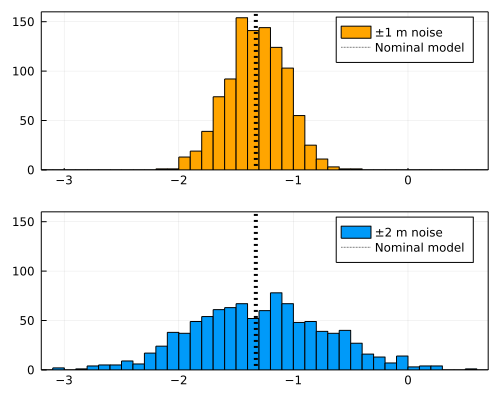

In [112]:
bins = (-3.2:0.1:0.7)
p1 = histogram(ω̇_pm1m*1e6, bins=bins, label="±1 m noise", color=:orange)
vline!([ω̇_nominal*1e6], label="Nominal model", linecolor=:black, linewidth=4, linestyle=:dot)
p2 = histogram(ω̇_pm2m*1e6, bins=bins, label="±2 m noise")
vline!([ω̇_nominal*1e6], label="Nominal model", linecolor=:black, linewidth=4, linestyle=:dot)

plot(p1, p2, layout=(2,1))
plot!(framestyle=:box, size=(500,400))
plot!(xlims=(-3.2, 0.7))
plot!(ylims=(0, 160))

In [114]:
savefig("./histogram.png")

# Tangential YORP effect

In [5]:
"""
`θ` : Thermal parameter as defined in Golubov (2017)
"""
function thermal_parameter(params)
    @unpack κ, C, ρ, A, ϵ, ω, Φ = params
    θ = (C*ρ*κ*ω)^0.5 / ((1-A)*Φ)^0.75 / (ϵ*σ_SB)^0.25
end

function length_cond(params)
    @unpack κ, A, Φ, ϵ = params
    L = κ / ((1-A)*Φ)^0.75 / (ϵ*σ_SB)^0.25
end

length_cond (generic function with 1 method)

In [6]:
"""
Three constants for dimensionless TYORP pressure.
Equation (36) and (37) in Golubov (2017).
"""
function constants(γ, coeffs)
    @unpack p0, Al, Aθ, All, Aθθ, Alθ = coeffs
    
    index = 2Aθ*Alθ*(Al-γ+3) - Aθθ*(Al-γ+3)^2 - Aθ*Aθ*All
    index /= 2(Aθθ*All - Alθ*Alθ)
    μ = p0 * √(2π/-All) * exp(index)
    ν = √(-2All/(Aθθ*All-Alθ*Alθ))
    lnθ₀ = (Alθ*(Al-γ+3) - Aθ*All) / (Aθθ*All-Alθ*Alθ)
    
    μ, ν, lnθ₀
end

"""
`p` : Dimensionless pressure at the equator
"""
function dimensionless_pressure_equator(n₀, γ, coeffs, params)
    # μ    = 0.00644
    # ν    = 1.518
    # lnθ₀ = 0.580
    
    μ, ν, lnθ₀ = constants(γ, coeffs)
    @show μ
    @show ν
    @show lnθ₀
    
    θ = thermal_parameter(params)
    lnθ = log(θ)
    index = - (lnθ - lnθ₀)^2 / ν^2
    p = n₀ * μ * exp(index)
end

"""
`p`  : Dimensionless pressure at the equator
`τω` : Dimensitonal TYORP torque 
"""
function TYORP_torque(p, params)
    @unpack ε, Φ, R = params
    τω = 9 * p                # Dimensionless pressure integrated over the entire surface
    τω *= (1 + cos(ε)^2) / 2  # Obliquity-dependence of TYORP (Sevecek et al. 2016)
    τω *= Φ * R^3 / c₀        # Dimensional TYORP
end

TYORP_torque

In [7]:
coeffs_Taylor = (
    p0  = 0.00350,
    Al  = 0.270,
    Aθ  = 0.912,
    All = -1.81,
    Aθθ = -3.47,
    Alθ = -1.93,
    
    μ    = 0.00763,
    ν    = 1.191,
    lnθ₀ = 0.442,
    α₀   = -0.659,
)

coeffs_numerics = (
    p0  = 0.00234,
    Al  = -0.540,
    Aθ  = -0.047,
    All = -1.37,
    Aθθ = -2.30,
    Alθ = -1.40,
    
    μ    = 0.00644,
    ν    = 1.518,
    lnθ₀ = 0.580,
    α₀   = -0.723,
);

In [8]:
## Surface area
S_Itokawa = 407303.3766111294    # itokawa_v1579014_f3145728
S_Ryugu   = 2.785753739269782e6  # SHAPE_SPC_3M_v20200323

2.785753739269782e6

In [9]:
## Power-index of bouder size frequency distribution on Ryugu (Michikami et al., 2018)
##     -2.65 ± 0.05 (>5m, global)
##     -2.01 ± 0.06 (0.1–4.1m, close-up image)
##     -1.65 ± 0.05 (0.02–3.26, close-up image)

df = DataFrame()
df.Data  = ["Ryugu global", "Close-up b", "Close-up c", "Close-up d", "Close-up e", "Close-up f", "Itokawa global"]
df.D_min = [ 5.8, 0.46, 0.26, 0.17, 0.09, 0.04, 7.52]  # Minimum diameter of boulders for fitting
df.N_fit = [3153, 1301, 1321,  721,  492, 1087,  318]  # Number of boulders for fitting
df.γ     = [2.65, 2.07, 2.01, 1.96, 1.98, 1.65, 3.52]  # Power-index
df.δγ    = [0.05, 0.06, 0.06, 0.07, 0.09, 0.05, 0.20]  # Error of power-index
df.S_obs = [S_Ryugu, 3843.9361906592353, 1024.002621446711, 225.00225002250022, 60.83835249741437, 44.88934775777708, S_Itokawa]  # Observed area [m²]

df.N₀  = @. df.N_fit * df.D_min^df.γ                               # Constant of boulder-size frequency distribution
df.δN₀ = @. abs(df.N_fit * df.D_min^df.γ * log(df.D_min) * df.δγ)  # Error of N₀

## Asuming the same bouder-size frequency distribution as Itokawa (Sevecek et al. 2015)
##     N(l) dl = (14000 ± 9000) l^(-3.0 ± 0.2) dl
push!(df, ("Itokawa Sevecek", 0, 0, 3.0, 0.2, S_Itokawa, 14000, 9000))
push!(df, ("Ryugu Sevecek",   0, 0, 3.0, 0.2, S_Ryugu,   14000*(S_Ryugu/S_Itokawa), 9000*(S_Ryugu/S_Itokawa)))

df.n₀ = @. π/4 * df.N₀ / df.S_obs

## Scale to global surface
@. df.N₀[2:6]  *= S_Ryugu / df.S_obs[2:6]
@. df.δN₀[2:6] *= S_Ryugu / df.S_obs[2:6]

df

,Data,D_min,N_fit,γ,δγ,S_obs,N₀,δN₀,n₀
,String,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,Ryugu global,5.8,3153,2.65,0.05,2.78575e6,3.32513e5,29225.5,0.0937466
2,Close-up b,0.46,1301,2.07,0.06,3843.94,1.88952e5,8803.62,0.0532721
3,Close-up c,0.26,1321,2.01,0.06,1024.0,239685.0,19372.4,0.0675753
4,Close-up d,0.17,721,1.96,0.07,225.002,2.76931e5,34349.6,0.0780761
5,Close-up e,0.09,492,1.98,0.09,60.8384,1.91483e5,41497.3,0.0539856
6,Close-up f,0.04,1087,1.65,0.05,44.8893,3.32988e5,53592.3,0.0938804
7,Itokawa global,7.52,318,3.52,0.2,4.07303e5,3.86113e5,1.55802e5,0.744536
8,Itokawa Sevecek,0.0,0,3.0,0.2,4.07303e5,14000.0,9000.0,0.026996
9,Ryugu Sevecek,0.0,0,3.0,0.2,2.78575e6,95753.1,61555.6,0.026996


In [29]:
params_Ryugu = (
    κ = 0.1,  # W/m/K (cracked rock)
    C = 680,   # J/kg/K
    ρ = 1190,
    A = 0.04,
    ϵ = 0.9,
    ω = 2π/(7.63262*3600),
    Φ = SOLAR_CONST/1.190^2,
    R = 449.1384853555837, # radius of the asteroid
    MOI = 4.039541372643629e16,  # Moment of inertia
    S = S_Ryugu,
    ε = deg2rad(171.65664649001607),
)

(κ = 0.1, C = 680, ρ = 1190, A = 0.04, ϵ = 0.9, ω = 0.00022866712242903872, Φ = 964.621142574677, R = 449.1384853555837, MOI = 4.039541372643629e16, S = 2.785753739269782e6, ε = 2.995973664182748)

In [30]:
θ = thermal_parameter(params_Ryugu)
L = length_cond(params_Ryugu)
@show θ
@show L;

θ = 1.7048855569637251
L = 0.039633774243746214


In [73]:
## Choose a parameter set of bouder distribution
Data, γ, δγ, N₀, δN₀, n₀ = df[1, [:Data, :γ, :δγ, :N₀, :δN₀, :n₀]]

,Data,γ,δγ,N₀,δN₀,n₀
,String,Float64,Float64,Float64,Float64,Float64
1,Ryugu global,2.65,0.05,3.32513e5,29225.5,0.0937466


In [74]:
μ, ν, lnθ₀ = constants(γ, coeffs_numerics);

In [75]:
p = dimensionless_pressure_equator(n₀, γ, coeffs_numerics, params_Ryugu)
τω_TYORP = TYORP_torque(p, params_Ryugu)

μ = 0.005141345387438451
ν = 1.5167688490319766
lnθ₀ = 0.1692779177162048


1.1811712719074046

In [76]:
ω̇_TYORP = τω_TYORP / params_Ryugu.MOI     # [rad/s/s]
ω̇_TYORP = rad2deg(ω̇_TYORP) * (3600*24)^2  # [deg/d/d]

1.2506360191961505e-5

In [77]:
println("======== ", Data, " ========")
@show n₀
@show γ

@show μ
@show ν
@show lnθ₀

@show p
@show τω_TYORP
@show ω̇_TYORP;

======== Ryugu global ========
n₀ = 0.09374655406897066
γ = 2.65
μ = 0.005141345387438451
ν = 1.5167688490319766
lnθ₀ = 0.1692779177162048
p = 0.0004549774248962667
τω_TYORP = 1.1811712719074046
ω̇_TYORP = 1.2506360191961505e-5


In [78]:
# ======== Ryugu global ======== 2–140 <- size range [m]
# n₀ = 0.09374655406897066
# γ = 2.65
# μ = 0.005141345387438451
# ν = 1.5167688490319766
# lnθ₀ = 0.1692779177162048
# p = 0.0004549774248962667
# τω_TYORP = 1.1937386122467606
# ω̇_TYORP = 1.2639424455101894e-5

# ======== Close-up b ======== 0.2–9.1
# n₀ = 0.05327208805469053
# γ = 2.07
# μ = 0.005937957218277187
# ν = 1.5167688490319766
# lnθ₀ = -0.5125020990764065
# p = 0.0001966049789541001
# τω_TYORP = 0.5158386809872615
# ω̇_TYORP = 5.461751821101479e-6

# ======== Close-up c ======== 0.1–4.1
# n₀ = 0.06757531206584438
# γ = 2.01
# μ = 0.0062547740517584485
# ν = 1.5167688490319766
# lnθ₀ = -0.5830310663308147
# p = 0.0002458471644946702
# τω_TYORP = 0.645036955483188
# ω̇_TYORP = 6.829716142157738e-6

# ======== Close-up d ======== 0.05–3.37
# n₀ = 0.07807611065495522
# γ = 1.96
# μ = 0.006566442598752409
# ν = 1.5167688490319766
# lnθ₀ = -0.6418052057094877
# p = 0.00028124557607076244
# τω_TYORP = 0.7379128838223102
# ω̇_TYORP = 7.813095809948138e-6

# ======== Close-up e ======== 0.02–1.83
# n₀ = 0.053985572088359864
# γ = 1.98
# μ = 0.006436223774895007
# ν = 1.5167688490319766
# lnθ₀ = -0.6182955499580184
# p = 0.00019519737896189825
# τω_TYORP = 0.5121455165150403
# ω̇_TYORP = 5.422648224327433e-6

# ======== Close-up f ======== 0.02–3.26
# n₀ = 0.09388043991502214
# γ = 1.65
# μ = 0.009886983320117684
# ν = 1.5167688490319766
# lnθ₀ = -1.0062048698572625
# p = 0.00033121638720619404
# τω_TYORP = 0.8690228762604087
# ω̇_TYORP = 9.201301592796497e-6

# ======== Ryugu Sevecek ========
# n₀ = 0.02699603027858578
# γ = 3.0
# μ = 0.0064538867868767546
# ν = 1.5167688490319766
# lnθ₀ = 0.5806968933669185
# p = 0.00017406069263338147
# τω_TYORP = 0.45668852628953305
# ω̇_TYORP = 4.835464035702287e-6

## Fraction of area covered with boulders with sizes from 0 to l

In [108]:
area_fraction(n₀, γ, l) = n₀ * l^(3-γ) / (3-γ)

area_fraction (generic function with 2 methods)

In [109]:
ls = 0:0.1:10
ns = area_fraction.(n₀, γ, ls)

101-element Vector{Float64}:
 0.0
 0.00698733396749282
 0.013878137852458824
 0.020732971157149033
 0.02756454910383504
 0.0343788864564819
 0.04117951612855445
 0.047968767613240974
 ⋮
 0.6276363330834814
 0.6342461951732263
 0.6408553615117204
 0.6474638394187314
 0.6540716360623495
 0.6606787584636449
 0.6672852135011396

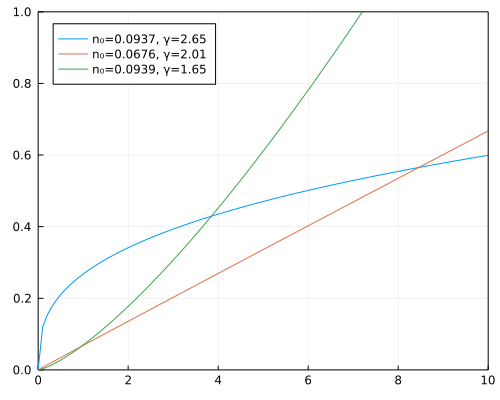

In [119]:
plot(framestyle=:box, size=(500,400))
plot!(xlims=(0,10))
plot!(ylims=(0,1))
plot!(legend=:topleft)

ls = 0:0.1:10

n₀ = 0.0937
γ  = 2.65
plot!(ls, area_fraction.(n₀, γ, ls), label="n₀=$n₀, γ=$γ")

n₀ = 0.0676
γ  = 2.01
plot!(ls, area_fraction.(n₀, γ, ls), label="n₀=$n₀, γ=$γ")

n₀ = 0.0939
γ  = 1.65
plot!(ls, area_fraction.(n₀, γ, ls), label="n₀=$n₀, γ=$γ")

## Normal YORP from 20 shape models

In [64]:
println("Moment of inertia    : ", params_Ryugu.MOI)  # [kg m²]
println("Maximum NYORP torque : ", deg2rad(-6.261e-6)  / (3600*24)^2 * params_Ryugu.MOI)  # [N m]
println("Minimum NYORP torque : ", deg2rad(-0.4212e-6) / (3600*24)^2 * params_Ryugu.MOI)  # [N m]

Moment of inertia    : 4.039541372643629e16
Maximum NYORP torque : -0.5913241918432524
Minimum NYORP torque : -0.03978050624570802


## Comparison with other asteroids using dimensionless TYORP

In [186]:
function nondim_YORP_coeff(ω̇, params)
    @unpack a, e, R, M = params
    Φ = SOLAR_CONST / a^2
    C₀ = c₀ * √(1-e^2) * M * ω̇ / (Φ * R)
end;

In [188]:
shapepath = "/Users/masanorikanamaru/Documents/shape/itokawa/itokawa_v1579014_f3145728.obj"
shape = setShapeModel(shapepath; scale=1000, find_visible_faces=false, save_shape=false)

Shape model


-----------
Nodes            : 1579014
Faces            : 3145728
Surface area     : 407303.3766111294
Volume           : 1.7731946996113643e7
Center-of-Figure : [0.07041065751044294, -0.0138597616674016, -0.04549024488855602]
Inertia tensor   : 
    | Ixx Ixy Ixz |   [0.0, 0.0, 0.0]
    | Iyx Iyy Iyz | = [0.0, 0.0, 0.0]
    | Izx Izy Izz |   [0.0, 0.0, 0.0]


In [210]:
ω̇_Itokawa = 3.54e-8       # [rad/day/day]
ω̇_Itokawa /= (3600*24)^2  # [rad/s/s]

params_Itokawa = (
    a  = 1.324198516024117,
    e  = 0.2800888606342457,
    R  = equivalent_radius(shape),
    M  = 3.51e10,
)

C₀_Itokawa = nondim_YORP_coeff(ω̇_Itokawa, params_Itokawa)

@show ω̇_Itokawa
@show params_Itokawa
@show C₀_Itokawa;

ω̇_Itokawa = 4.742155349794239e-18
params_Itokawa = (a = 1.324198516024117, e = 0.2800888606342457, R = 161.76675424428103, M = 3.51e10)
C₀_Itokawa = 0.000380127531207742


In [213]:
ω̇_Bennu = 3.63e-6  # [deg/day/day]
ω̇_Bennu = deg2rad(ω̇_Bennu) / (3600*24)^2  # [rad/s/s]

params_Bennu = (
    a  = 1.126391025894812,
    e  = 0.2037450762416414	,
    R  = 482/2,
    M  = 4.890450/G,
)

C₀_Bennu = nondim_YORP_coeff(ω̇_Bennu, params_Bennu)

@show ω̇_Bennu
@show params_Bennu
@show C₀_Bennu;

ω̇_Bennu = 8.487045054145523e-18
params_Bennu = (a = 1.126391025894812, e = 0.2037450762416414, R = 241.0, M = 7.32752338669562e10)
C₀_Bennu = 0.0007034583234377313


In [214]:
shapepath = "/Users/masanorikanamaru/Documents/shape/ryugu/SHAPE_SPC_3M_v20200323.obj"
shape = setShapeModel(shapepath; scale=1000, find_visible_faces=false, save_shape=false)

Shape model


-----------
Nodes            : 1579014
Faces            : 3145728
Surface area     : 2.785753739269782e6
Volume           : 3.795154140741222e8
Center-of-Figure : [-1.4102075181221139, 0.009231065747138278, 0.4315267919967862]
Inertia tensor   : 
    | Ixx Ixy Ixz |   [0.0, 0.0, 0.0]
    | Iyx Iyy Iyz | = [0.0, 0.0, 0.0]
    | Izx Izy Izz |   [0.0, 0.0, 0.0]


In [222]:
# ω̇_Ryugu = -0.4212e-6  # [deg/day/day]  # Maximum NYORP
# ω̇_Ryugu = -6.261e-6  # [deg/day/day]  # Minimum NYORP
# ω̇_Ryugu = 1.2639424455101894e-5  # [deg/day/day] # Maximum TYORP
ω̇_Ryugu = 4.835464035702287e-6  # [deg/day/day] # Minimum TYORP

ω̇_Ryugu = deg2rad(ω̇_Ryugu) / (3600*24)^2  # [rad/s/s]

params_Ryugu = (
    a  = 1.18956373,
    e  = 0.19027921,
    R  = equivalent_radius(shape),
    M  = 30.0/G,
)

C₀_Ryugu = nondim_YORP_coeff(ω̇_Ryugu, params_Ryugu)

@show ω̇_Ryugu
@show params_Ryugu
@show C₀_Ryugu;

ω̇_Ryugu = 1.1305454856392739e-17
params_Ryugu = (a = 1.18956373, e = 0.19027921, R = 449.1384853555837, M = 4.4949994704141455e11)
C₀_Ryugu = 0.0034496490603811844


# Detectabilty of YORP on Ryugu
- 7.63    ± 0.01     (Müller et al.,2011)
- 7.631   ± 0.005    (Moskovitz et al., 2013)
- 7.625   ± 0.003    (Kim et al.,2013)
- 7.63262 ± 0.00002  (Watanabe et al., 2019)

In [317]:
function predict(P₀, ω̇, ts)
    ω₀ = 360 / P₀  # [deg/s]
    
    df = DataFrame()
    df.t  = @. ts
    df.ω  = @. ω₀ + ω̇*ts
    df.P  = @. 360 / df.ω
    df.ϕ  = @. ω₀*ts + 0.5*ω̇*ts^2
    df.Δϕ = @.         0.5*ω̇*ts^2
    
    df
end

predict (generic function with 2 methods)

In [318]:
P₀  = 7.63262 * 3600  # [s]
δP₀ = 0.00002 * 3600  # [s]  (Watanabe et al. 2009)

ω̇_NYORP_max = -6.261e-6  / (3600*24)^2  # [deg/s/s]
ω̇_NYORP_min = -0.4212e-6 / (3600*24)^2  # [deg/s/s]

ω̇_TYORP_max = 1.2639424455101894e-5 / (3600*24)^2  # [deg/s/s]
ω̇_TYORP_min = 4.835464035702287e-6  / (3600*24)^2  # [deg/s/s]

ts = 0:3600*24*30:3600*24*365*20

0:2592000:629856000

In [319]:
df_NYORP_max = predict(P₀+δP₀, ω̇_NYORP_max, ts);
df_NYORP_min = predict(P₀-δP₀, ω̇_NYORP_min, ts);

df_NYORP_max_TYORP_min = predict(P₀+δP₀, ω̇_NYORP_max+ω̇_TYORP_min, ts);
df_NYORP_min_TYORP_min = predict(P₀-δP₀, ω̇_NYORP_min+ω̇_TYORP_min, ts);

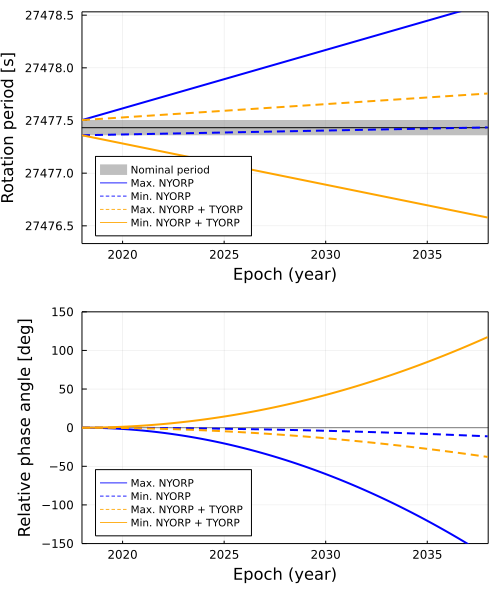

In [331]:
ts_year = collect(ts) / (3600*24*365) .+ 2018


p1 = plot(framestyle=:box)
plot!(xlims=(2018, 2018+20))
plot!(ylims=(P₀-1.1,P₀+1.1))
plot!(xlabel="Epoch (year)")
plot!(ylabel="Rotation period [s]")
plot!(legend=:bottomleft)

## 7.63262 ± 0.00002  (Watanabe et al., 2019)
hspan!([P₀-δP₀, P₀+δP₀], fill=(0.5, :gray), label="Nominal period")
hline!([P₀], line=(:black), label=false)

plot!(ts_year, df_NYORP_max.P, line=(2, :blue, :solid), label="Max. NYORP")
plot!(ts_year, df_NYORP_min.P, line=(2, :blue, :dash ), label="Min. NYORP")

plot!(ts_year, df_NYORP_max_TYORP_min.P, line=(2, :orange, :dash ), label="Max. NYORP + TYORP")
plot!(ts_year, df_NYORP_min_TYORP_min.P, line=(2, :orange, :solid), label="Min. NYORP + TYORP")

p2 = plot(framestyle=:box)
plot!(xlims=(2018, 2018+20))
plot!(ylims=(-150,150))
plot!(xlabel="Epoch (year)")
plot!(ylabel="Relative phase angle [deg]")
plot!(legend=:bottomleft)

hline!([0], line=(0.5, :black), label=false)

plot!(ts_year, df_NYORP_max.Δϕ, line=(2, :blue, :solid), label="Max. NYORP")
plot!(ts_year, df_NYORP_min.Δϕ, line=(2, :blue, :dash ), label="Min. NYORP")

plot!(ts_year, df_NYORP_max_TYORP_min.Δϕ, line=(2, :orange, :dash ), label="Max. NYORP + TYORP")
plot!(ts_year, df_NYORP_min_TYORP_min.Δϕ, line=(2, :orange, :solid), label="Min. NYORP + TYORP")

plot(p1, p2, layout=(2,1), size=(500,600))
# plot!(legendfont=font(8, "Times"))
plot!(legendfont=font(7), tickfont=(8))

In [334]:
savefig("spin_params_evolution.pdf")